In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import joblib
import datetime
import warnings
warnings.simplefilter("ignore")


In [2]:
# Global Parameters
ticker = 'GOOGL'
start_date = '2016-01-01'
end_date = datetime.datetime.today().strftime('%Y-%m-%d')

Fetching historical data...


[*********************100%%**********************]  1 of 1 completed


Fetching financial metrics...
Computing ...
Training the model...

--- Model Evaluation ---
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.58      0.48       187
           1       0.53      0.36      0.43       244

    accuracy                           0.46       431
   macro avg       0.47      0.47      0.46       431
weighted avg       0.48      0.46      0.45       431

Confusion Matrix:
[[108  79]
 [155  89]]
ROC AUC Score: 0.4654
Performing backtesting...


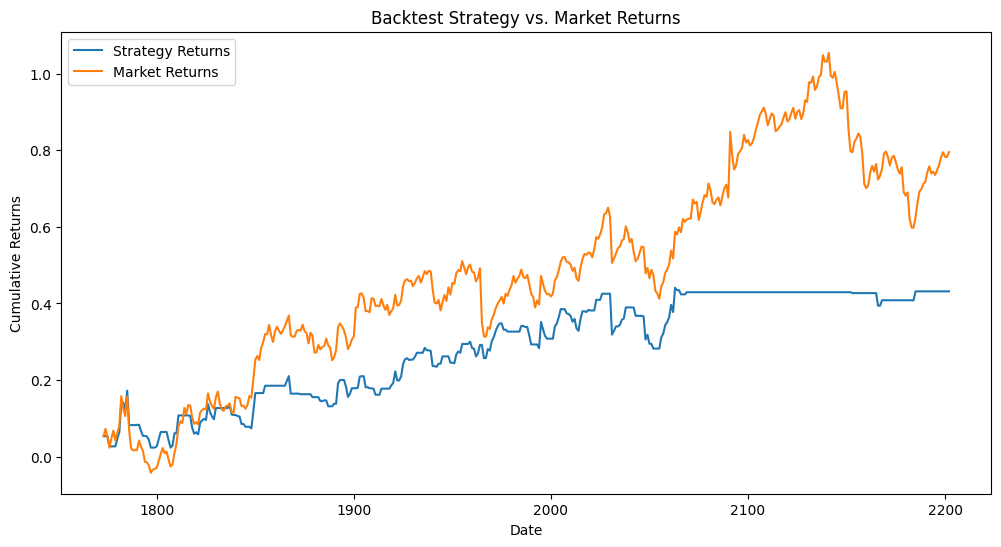

Saving the model and scaler...
Model and scaler saved.

--- Buy/Sell Signal Prediction ---


Rate your sentiment on recent news (1-5, where 1=Extremely Negative and 5=Extremely Positive):  4


Recommended Action: Sell


In [3]:
def fetch_historical_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data.reset_index(inplace=True)
    return data

def fetch_financial_metrics(ticker):
    stock = yf.Ticker(ticker)
    info = stock.info
    financial_metrics = {
        'PE_Ratio': info.get('trailingPE', np.nan),
        'Debt_to_Equity': info.get('debtToEquity', np.nan),
        'Return_on_Equity': info.get('returnOnEquity', np.nan),
        'Beta': info.get('beta', np.nan)
    }
    return financial_metrics

def compute_moving_averages(data, windows=[20, 50]):
    for window in windows:
        data[f'MA{window}'] = data['Close'].rolling(window=window).mean()
    return data

def compute_RSI(data, period=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    RS = gain / loss
    data['RSI'] = 100 - (100 / (1 + RS))
    return data

def simulate_user_sentiment(data):
    """
    Simulate user sentiment as a random value between 1 (Extremely Negative) and 5 (Extremely Positive).
    In a real-world scenario, you would collect this data from user inputs.
    """
    np.random.seed(42)  # For reproducibility
    data['User_Sentiment'] = np.random.randint(1, 6, size=len(data))
    return data

def define_target_variable(data):
    data['Target'] = (data['Close'].shift(-1) > data['Close']).astype(int)
    data = data.dropna()  # Drop the last row with NaN target
    return data

def incorporate_financial_metrics(data, metrics):
    for key, value in metrics.items():
        data[key] = value
    return data

def select_features(data):
    features = ['MA20', 'MA50', 'RSI', 'PE_Ratio', 'Debt_to_Equity', 'Return_on_Equity', 'Beta', 'User_Sentiment']
    X = data[features]
    y = data['Target']
    return X, y

def train_test_split_data(X, y, test_size=0.2):
    split_index = int(len(X) * (1 - test_size))
    X_train = X.iloc[:split_index]
    X_test = X.iloc[split_index:]
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]
    return X_train, X_test, y_train, y_test

def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return scaler, X_train_scaled, X_test_scaled

def train_model(X_train, y_train):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    print("\n--- Model Evaluation ---")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"ROC AUC Score: {roc_auc:.4f}")
    
    return y_pred, y_prob

def backtest_strategy(data, y_pred, test_size=0.2):
    split_index = int(len(data) * (1 - test_size))
    data_test = data.iloc[split_index:].copy()
    data_test['Predicted_Signal'] = y_pred
    data_test['Returns'] = data_test['Close'].pct_change().shift(-1)
    data_test['Strategy_Returns'] = data_test['Returns'] * data_test['Predicted_Signal']
    
    # Calculate cumulative returns
    cumulative_strategy = (1 + data_test['Strategy_Returns']).cumprod() - 1
    cumulative_market = (1 + data_test['Returns']).cumprod() - 1
    
    plt.figure(figsize=(12,6))
    plt.plot(cumulative_strategy, label='Strategy Returns')
    plt.plot(cumulative_market, label='Market Returns')
    plt.legend()
    plt.title('Backtest Strategy vs. Market Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.show()

def make_prediction(model, scaler, financial_metrics, latest_data):
    print("\n--- Buy/Sell Signal Prediction ---")
    try:
        user_sentiment = int(input("Rate your sentiment on recent news (1-5, where 1=Extremely Negative and 5=Extremely Positive): "))
        if user_sentiment < 1 or user_sentiment > 5:
            raise ValueError
    except ValueError:
        print("Invalid input. Please enter an integer between 1 and 5.")
        return
    
    # Prepare the feature vector
    feature_vector = {
        'MA20': latest_data['MA20'],
        'MA50': latest_data['MA50'],
        'RSI': latest_data['RSI'],
        'PE_Ratio': financial_metrics['PE_Ratio'],
        'Debt_to_Equity': financial_metrics['Debt_to_Equity'],
        'Return_on_Equity': financial_metrics['Return_on_Equity'],
        'Beta': financial_metrics['Beta'],
        'User_Sentiment': user_sentiment
    }
    
    feature_df = pd.DataFrame([feature_vector])
    
    # Handle missing financial metrics
    feature_df.fillna(method='ffill', inplace=True)
    
    # Scale the features
    feature_scaled = scaler.transform(feature_df)
    
    # Make prediction
    prediction = model.predict(feature_scaled)[0]
    signal = 'Buy' if prediction == 1 else 'Sell'
    
    print(f"Recommended Action: {signal}")

def main():
    # Parameters
    
    # Data Collection
    print("Fetching historical data...")
    historical_data = fetch_historical_data(ticker, start_date, end_date)
    
    print("Fetching financial metrics...")
    financial_metrics = fetch_financial_metrics(ticker)
    
    # Feature Engineering
    print("Computing ...")
    historical_data = compute_moving_averages(historical_data)
    historical_data = compute_RSI(historical_data)
    historical_data = simulate_user_sentiment(historical_data)
    historical_data = define_target_variable(historical_data)
    historical_data = incorporate_financial_metrics(historical_data, financial_metrics)
    
    X, y = select_features(historical_data)
    
    X = X.dropna()
    y = y.loc[X.index]
    
    X_train, X_test, y_train, y_test = train_test_split_data(X, y)
    scaler, X_train_scaled, X_test_scaled = scale_features(X_train, X_test)
    
    # Model Training
    print("Training the model...")
    model = train_model(X_train_scaled, y_train)
    y_pred, y_prob = evaluate_model(model, X_test_scaled, y_test)
    
    # Backtesting
    print("Performing backtesting...")
    backtest_strategy(historical_data, y_pred)
    
    # Save the model and scaler for future use
    print("Saving the model and scaler...")
    joblib.dump(model, 'stock_buy_sell_model.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    print("Model and scaler saved.")
    
    # Making a prediction based on the latest data and user input
    latest_data = historical_data.iloc[-1]
    make_prediction(model, scaler, financial_metrics, latest_data)

if __name__ == "__main__":
    main()
